In [1]:
import numpy as np
from scipy import interpolate
import matplotlib.pyplot as plt
import random
import h5py
import copy
import os
os.environ['CUDA_VISIBLE_DEVICES']='0'
import tensorflow as tf

In [2]:
def generator_f(data,size,snr,X,Y_):
    signal=np.zeros([size,8192])
    label=np.zeros([size,2])
    data=random.sample(data,size/2)
    data=np.array(data)
    for i in range(size):
        if i%2==0:
            r=random.randint(0,1638)
            label[i]=[0,1]
            signal[i,0:8191-r:1]=data[i/2,r:8191:1]*snr
            signal[i]+=np.random.normal(0,1,8192)
            signal[i]=signal[i]/np.std(signal[i])
        else:
            label[i]=[1,0]
            signal[i]=np.random.normal(0,1,8192)
    feed_dict={
        X:signal,
        Y_:label,
    }
    return feed_dict    

def generator_r(data,size,snr,X,Y_):
    signal=np.zeros([size,8192])
    label=np.zeros([size,2])
    data=random.sample(data,size/2)
    data=np.array(data)
    for i in range(size):
        if i%2==0:
            r=random.randint(0,1638)
            label[i]=[0,1]
            signal[i,0:8191-r:1]=data[i/2,r:8191:1]*random.uniform(snr,2)
            signal[i]+=np.random.normal(0,1,8192)
            signal[i]=signal[i]/np.std(signal[i])
        else:
            label[i]=[1,0]
            signal[i]=np.random.normal(0,1,8192)
    feed_dict={
        X:signal,
        Y_:label,
    }
    return feed_dict    

In [3]:
#get data
f=h5py.File('dataset.h5','r')
testsig=list(f['test'])
trainsig=list(f['train'])


In [4]:
sess=tf.Session()

#initial weight
def weight_variable(name,shape):
    return tf.get_variable(name,shape=shape,initializer=tf.contrib.layers.xavier_initializer())
#intial bias
def bias_variable(name,shape):
    return tf.get_variable(name,shape=shape,initializer=tf.constant_initializer(0.1))
#placeholder
with tf.name_scope('Input'):
    X=tf.placeholder(tf.float32,[None,8192])
with tf.name_scope('Label'):
    Y_=tf.placeholder(tf.float32,[None,2])

#reshape layer
with tf.name_scope('Reshape_layer'):
    XX=tf.reshape(X,[-1,8192,1,1])
#convolution layer 1
w_conv1=weight_variable('w_conv1',[16,1,1,16])
b_conv1=bias_variable('b_conv1',[16])
with tf.name_scope('Convolution_layer1'):
    conv1=tf.nn.conv2d(XX,w_conv1,strides=[1,1,1,1],padding='VALID')
print(conv1.shape)

#activation layer 1
with tf.name_scope('Relu_layer1'):
    h_conv1=tf.nn.elu(conv1+b_conv1)

#pooling layer 1
with tf.name_scope('Pooling_layer1'):
    h_pool1=tf.nn.max_pool(h_conv1,[1,4,1,1],strides=[1,4,1,1],padding='SAME')
print(h_pool1.shape)

#convolution layer 2
w_conv2=weight_variable('w_conv2',[8,1,16,32])
b_conv2=bias_variable('b_conv2',[32])
with tf.name_scope('Convolution_layer2'):
    conv2=tf.nn.atrous_conv2d(h_pool1,w_conv2,rate=4,padding='VALID')
print(conv2.shape)

#activation layer 2
with tf.name_scope('Relu_layer2'):
    h_conv2=tf.nn.elu(conv2+b_conv2)

#pooling layer 2
with tf.name_scope('Pooling_layer2'):
    h_pool2=tf.nn.max_pool(h_conv2,ksize=[1,4,1,1],strides=[1,4,1,1],padding='SAME')
print(h_pool2)

#convolution layer 3
w_conv3=weight_variable('w_conv3',[8,1,32,64])
b_conv3=bias_variable('b_conv3',[64])
with tf.name_scope('Convolution_layer3'):
    conv3=tf.nn.atrous_conv2d(h_pool2,w_conv3,rate=4,padding='VALID')
print(conv3)

#activation layer 3
with tf.name_scope('Relu_layer3'):
    h_conv3=tf.nn.elu(conv3+b_conv3)

#pooling layer 3
with tf.name_scope('Pooling_layer3'):
    h_pool3=tf.nn.max_pool(h_conv3,ksize=[1,4,1,1],strides=[1,4,1,1],padding='SAME')
print(h_pool3.shape)

#flatten layer
with tf.name_scope('Flatten_layer'):
    h_flatten=tf.reshape(h_pool3,[-1,7680])
print(h_flatten.shape)

#linear layer 1
w_linear1=weight_variable('w_linear1',[7680,64])
b_linear1=bias_variable('b_linear1',[64])

#activation layer 4
with tf.name_scope('Relu_layer4'):
    h_linear1=tf.nn.elu(tf.matmul(h_flatten,w_linear1)+b_linear1)

#linear layer 2
w_linear2=weight_variable('w_linear2',[64,2])
b_linear2=bias_variable('b_linear2',[2])

#activation layer 5
Ylogits=tf.matmul(h_linear1,w_linear2)+b_linear2
with tf.name_scope('Output'):
    Y=tf.nn.softmax(Ylogits)

#loss function
cross_entropy=tf.nn.softmax_cross_entropy_with_logits(logits=Ylogits,labels=Y_)
cross_entropy=tf.reduce_mean(cross_entropy)

#accuracy
is_correct=tf.equal(tf.argmax(Y,1),tf.argmax(Y_,1))
accuracy=tf.reduce_mean(tf.cast(is_correct,tf.float32))*100

#optimization
optimizer=tf.train.AdamOptimizer(0.0001)
global_step = tf.Variable(0, name='global_step', trainable=False)
train_step=optimizer.minimize(cross_entropy,global_step=global_step)

#save the model
saver=tf.train.Saver()

#visualization
tf.summary.scalar('accuracy',accuracy)
tf.summary.scalar('cross_entropy',tf.log(cross_entropy))
merged=tf.summary.merge_all()
train_writer=tf.summary.FileWriter('/home/txie/project/classifier1/train/',sess.graph)
test_writer=tf.summary.FileWriter('/home/txie/project/classifier1/test/')

#run
sess.run(tf.global_variables_initializer())

(?, 8177, 1, 16)
(?, 2045, 1, 16)
(?, ?, ?, 32)
Tensor("Pooling_layer2/MaxPool:0", shape=(?, ?, ?, 32), dtype=float32)
Tensor("Convolution_layer3/atrous_conv2d/BatchToSpaceND:0", shape=(?, ?, ?, 64), dtype=float32)
(?, ?, ?, 64)
(?, 7680)


In [5]:
#restore the model
ckpt = tf.train.get_checkpoint_state('/home/txie/project/classifier1')  
saver.restore(sess,ckpt.model_checkpoint_path)
print('Model Restored')

Model Restored


In [6]:
#get test data
snr=0.25
test=generator_f(testsig,1480,snr,X,Y_)

In [7]:
#training loop
epoch=5000
for i in range(epoch):
    if (i+1)%100==0:
        summary,a,c=sess.run([merged,accuracy,cross_entropy],feed_dict=test)
        print('test:'+' accuracy:'+str(a)+' cross_entropy:'+str(c))
        test_writer.add_summary(summary,tf.train.global_step(sess,global_step))
    feed_dict=generator_r(trainsig,50,snr,X,Y_)
    a,c=sess.run([accuracy,cross_entropy],feed_dict=feed_dict)
    print('epoch:'+str(i)+' accuracy:'+str(a)+' cross_entropy:'+str(c))
    summary,_=sess.run([merged,train_step],feed_dict=feed_dict)
    train_writer.add_summary(summary,tf.train.global_step(sess,global_step))


epoch:0 accuracy:98.0 cross_entropy:0.0473042
epoch:1 accuracy:100.0 cross_entropy:0.00370697
epoch:2 accuracy:98.0 cross_entropy:0.0261754
epoch:3 accuracy:98.0 cross_entropy:0.0443424
epoch:4 accuracy:100.0 cross_entropy:0.00871312
epoch:5 accuracy:98.0 cross_entropy:0.0375337
epoch:6 accuracy:98.0 cross_entropy:0.0694793
epoch:7 accuracy:100.0 cross_entropy:0.0106903
epoch:8 accuracy:100.0 cross_entropy:0.0113917
epoch:9 accuracy:100.0 cross_entropy:0.0141271
epoch:10 accuracy:100.0 cross_entropy:0.00446536
epoch:11 accuracy:100.0 cross_entropy:0.00291065
epoch:12 accuracy:100.0 cross_entropy:0.0190207
epoch:13 accuracy:100.0 cross_entropy:0.0093247
epoch:14 accuracy:100.0 cross_entropy:0.0037727
epoch:15 accuracy:100.0 cross_entropy:0.00571942
epoch:16 accuracy:100.0 cross_entropy:0.00435883
epoch:17 accuracy:96.0 cross_entropy:0.0735591
epoch:18 accuracy:98.0 cross_entropy:0.0252953
epoch:19 accuracy:100.0 cross_entropy:0.0166507
epoch:20 accuracy:96.0 cross_entropy:0.0555977
epoc

epoch:172 accuracy:100.0 cross_entropy:0.0135071
epoch:173 accuracy:100.0 cross_entropy:0.0109423
epoch:174 accuracy:100.0 cross_entropy:0.00908638
epoch:175 accuracy:100.0 cross_entropy:0.0106959
epoch:176 accuracy:100.0 cross_entropy:0.0102556
epoch:177 accuracy:100.0 cross_entropy:0.0196411
epoch:178 accuracy:100.0 cross_entropy:0.0116568
epoch:179 accuracy:96.0 cross_entropy:0.0899483
epoch:180 accuracy:98.0 cross_entropy:0.0501949
epoch:181 accuracy:100.0 cross_entropy:0.046409
epoch:182 accuracy:98.0 cross_entropy:0.0284651
epoch:183 accuracy:98.0 cross_entropy:0.0271497
epoch:184 accuracy:94.0 cross_entropy:0.131418
epoch:185 accuracy:98.0 cross_entropy:0.0811427
epoch:186 accuracy:94.0 cross_entropy:0.198383
epoch:187 accuracy:98.0 cross_entropy:0.0574246
epoch:188 accuracy:98.0 cross_entropy:0.100577
epoch:189 accuracy:98.0 cross_entropy:0.0372524
epoch:190 accuracy:98.0 cross_entropy:0.0602167
epoch:191 accuracy:96.0 cross_entropy:0.170843
epoch:192 accuracy:100.0 cross_entro

epoch:340 accuracy:98.0 cross_entropy:0.0270141
epoch:341 accuracy:100.0 cross_entropy:0.00606601
epoch:342 accuracy:100.0 cross_entropy:0.0107497
epoch:343 accuracy:100.0 cross_entropy:0.00545035
epoch:344 accuracy:100.0 cross_entropy:0.00346167
epoch:345 accuracy:98.0 cross_entropy:0.097326
epoch:346 accuracy:100.0 cross_entropy:0.00647046
epoch:347 accuracy:96.0 cross_entropy:0.113429
epoch:348 accuracy:96.0 cross_entropy:0.0680271
epoch:349 accuracy:98.0 cross_entropy:0.0440902
epoch:350 accuracy:100.0 cross_entropy:0.00431251
epoch:351 accuracy:98.0 cross_entropy:0.0902487
epoch:352 accuracy:98.0 cross_entropy:0.127664
epoch:353 accuracy:100.0 cross_entropy:0.012003
epoch:354 accuracy:98.0 cross_entropy:0.0758618
epoch:355 accuracy:100.0 cross_entropy:0.0202193
epoch:356 accuracy:98.0 cross_entropy:0.102768
epoch:357 accuracy:100.0 cross_entropy:0.00666971
epoch:358 accuracy:100.0 cross_entropy:0.0180435
epoch:359 accuracy:100.0 cross_entropy:0.00889132
epoch:360 accuracy:100.0 cr

epoch:508 accuracy:98.0 cross_entropy:0.0415849
epoch:509 accuracy:98.0 cross_entropy:0.0273933
epoch:510 accuracy:98.0 cross_entropy:0.0402614
epoch:511 accuracy:100.0 cross_entropy:0.0210404
epoch:512 accuracy:100.0 cross_entropy:0.010434
epoch:513 accuracy:96.0 cross_entropy:0.159396
epoch:514 accuracy:98.0 cross_entropy:0.0766219
epoch:515 accuracy:98.0 cross_entropy:0.105315
epoch:516 accuracy:100.0 cross_entropy:0.0120664
epoch:517 accuracy:96.0 cross_entropy:0.103214
epoch:518 accuracy:100.0 cross_entropy:0.0289629
epoch:519 accuracy:100.0 cross_entropy:0.0123222
epoch:520 accuracy:100.0 cross_entropy:0.00753066
epoch:521 accuracy:100.0 cross_entropy:0.00521895
epoch:522 accuracy:98.0 cross_entropy:0.0805252
epoch:523 accuracy:100.0 cross_entropy:0.0141861
epoch:524 accuracy:100.0 cross_entropy:0.016175
epoch:525 accuracy:100.0 cross_entropy:0.00904006
epoch:526 accuracy:98.0 cross_entropy:0.0239863
epoch:527 accuracy:100.0 cross_entropy:0.00769093
epoch:528 accuracy:98.0 cross_

epoch:678 accuracy:100.0 cross_entropy:0.016835
epoch:679 accuracy:98.0 cross_entropy:0.0478863
epoch:680 accuracy:94.0 cross_entropy:0.139919
epoch:681 accuracy:96.0 cross_entropy:0.137587
epoch:682 accuracy:98.0 cross_entropy:0.133967
epoch:683 accuracy:98.0 cross_entropy:0.0562355
epoch:684 accuracy:98.0 cross_entropy:0.0943319
epoch:685 accuracy:94.0 cross_entropy:0.138305
epoch:686 accuracy:96.0 cross_entropy:0.0575211
epoch:687 accuracy:98.0 cross_entropy:0.101451
epoch:688 accuracy:100.0 cross_entropy:0.00913928
epoch:689 accuracy:96.0 cross_entropy:0.135082
epoch:690 accuracy:100.0 cross_entropy:0.0179493
epoch:691 accuracy:96.0 cross_entropy:0.110132
epoch:692 accuracy:98.0 cross_entropy:0.049519
epoch:693 accuracy:100.0 cross_entropy:0.00852481
epoch:694 accuracy:100.0 cross_entropy:0.00547479
epoch:695 accuracy:100.0 cross_entropy:0.00981155
epoch:696 accuracy:96.0 cross_entropy:0.13042
epoch:697 accuracy:100.0 cross_entropy:0.0130225
epoch:698 accuracy:96.0 cross_entropy:0.

epoch:846 accuracy:100.0 cross_entropy:0.00817394
epoch:847 accuracy:98.0 cross_entropy:0.0561788
epoch:848 accuracy:96.0 cross_entropy:0.0520152
epoch:849 accuracy:100.0 cross_entropy:0.00778287
epoch:850 accuracy:100.0 cross_entropy:0.0119738
epoch:851 accuracy:100.0 cross_entropy:0.00449523
epoch:852 accuracy:98.0 cross_entropy:0.0995661
epoch:853 accuracy:96.0 cross_entropy:0.116761
epoch:854 accuracy:100.0 cross_entropy:0.0123203
epoch:855 accuracy:94.0 cross_entropy:0.221505
epoch:856 accuracy:98.0 cross_entropy:0.103425
epoch:857 accuracy:96.0 cross_entropy:0.165175
epoch:858 accuracy:98.0 cross_entropy:0.0472455
epoch:859 accuracy:100.0 cross_entropy:0.00479379
epoch:860 accuracy:100.0 cross_entropy:0.00698255
epoch:861 accuracy:98.0 cross_entropy:0.034053
epoch:862 accuracy:100.0 cross_entropy:0.0257117
epoch:863 accuracy:98.0 cross_entropy:0.0458822
epoch:864 accuracy:100.0 cross_entropy:0.0100857
epoch:865 accuracy:100.0 cross_entropy:0.0115859
epoch:866 accuracy:100.0 cross

epoch:1013 accuracy:100.0 cross_entropy:0.010019
epoch:1014 accuracy:96.0 cross_entropy:0.121264
epoch:1015 accuracy:98.0 cross_entropy:0.102282
epoch:1016 accuracy:98.0 cross_entropy:0.0848016
epoch:1017 accuracy:100.0 cross_entropy:0.022833
epoch:1018 accuracy:98.0 cross_entropy:0.0388611
epoch:1019 accuracy:100.0 cross_entropy:0.0274192
epoch:1020 accuracy:100.0 cross_entropy:0.0196272
epoch:1021 accuracy:100.0 cross_entropy:0.0222585
epoch:1022 accuracy:100.0 cross_entropy:0.00959507
epoch:1023 accuracy:98.0 cross_entropy:0.0603921
epoch:1024 accuracy:100.0 cross_entropy:0.00763285
epoch:1025 accuracy:100.0 cross_entropy:0.0105583
epoch:1026 accuracy:98.0 cross_entropy:0.0716308
epoch:1027 accuracy:98.0 cross_entropy:0.0331821
epoch:1028 accuracy:100.0 cross_entropy:0.0184893
epoch:1029 accuracy:96.0 cross_entropy:0.158237
epoch:1030 accuracy:100.0 cross_entropy:0.0148419
epoch:1031 accuracy:98.0 cross_entropy:0.0467413
epoch:1032 accuracy:98.0 cross_entropy:0.126844
epoch:1033 acc

epoch:1179 accuracy:100.0 cross_entropy:0.00684675
epoch:1180 accuracy:100.0 cross_entropy:0.0101532
epoch:1181 accuracy:100.0 cross_entropy:0.016981
epoch:1182 accuracy:100.0 cross_entropy:0.015813
epoch:1183 accuracy:100.0 cross_entropy:0.00379688
epoch:1184 accuracy:100.0 cross_entropy:0.0116705
epoch:1185 accuracy:98.0 cross_entropy:0.0493818
epoch:1186 accuracy:100.0 cross_entropy:0.0150078
epoch:1187 accuracy:98.0 cross_entropy:0.100269
epoch:1188 accuracy:100.0 cross_entropy:0.0108852
epoch:1189 accuracy:100.0 cross_entropy:0.00595781
epoch:1190 accuracy:94.0 cross_entropy:0.0800036
epoch:1191 accuracy:98.0 cross_entropy:0.0716914
epoch:1192 accuracy:98.0 cross_entropy:0.0693537
epoch:1193 accuracy:100.0 cross_entropy:0.0106509
epoch:1194 accuracy:100.0 cross_entropy:0.0152185
epoch:1195 accuracy:98.0 cross_entropy:0.0352043
epoch:1196 accuracy:100.0 cross_entropy:0.0210641
epoch:1197 accuracy:98.0 cross_entropy:0.0553726
epoch:1198 accuracy:98.0 cross_entropy:0.107359
test: acc

epoch:1343 accuracy:96.0 cross_entropy:0.0946122
epoch:1344 accuracy:98.0 cross_entropy:0.0374801
epoch:1345 accuracy:98.0 cross_entropy:0.0573388
epoch:1346 accuracy:100.0 cross_entropy:0.00764878
epoch:1347 accuracy:98.0 cross_entropy:0.0873377
epoch:1348 accuracy:94.0 cross_entropy:0.111824
epoch:1349 accuracy:96.0 cross_entropy:0.0729135
epoch:1350 accuracy:98.0 cross_entropy:0.0699346
epoch:1351 accuracy:94.0 cross_entropy:0.138752
epoch:1352 accuracy:100.0 cross_entropy:0.0115932
epoch:1353 accuracy:100.0 cross_entropy:0.025646
epoch:1354 accuracy:98.0 cross_entropy:0.0417916
epoch:1355 accuracy:100.0 cross_entropy:0.0184855
epoch:1356 accuracy:98.0 cross_entropy:0.0286559
epoch:1357 accuracy:100.0 cross_entropy:0.0134528
epoch:1358 accuracy:100.0 cross_entropy:0.0224876
epoch:1359 accuracy:96.0 cross_entropy:0.0840376
epoch:1360 accuracy:96.0 cross_entropy:0.157291
epoch:1361 accuracy:100.0 cross_entropy:0.00482619
epoch:1362 accuracy:98.0 cross_entropy:0.09405
epoch:1363 accura

epoch:1509 accuracy:98.0 cross_entropy:0.0239197
epoch:1510 accuracy:100.0 cross_entropy:0.015093
epoch:1511 accuracy:98.0 cross_entropy:0.0820381
epoch:1512 accuracy:98.0 cross_entropy:0.0827308
epoch:1513 accuracy:100.0 cross_entropy:0.00975639
epoch:1514 accuracy:96.0 cross_entropy:0.0467033
epoch:1515 accuracy:98.0 cross_entropy:0.114521
epoch:1516 accuracy:100.0 cross_entropy:0.0136836
epoch:1517 accuracy:100.0 cross_entropy:0.0194983
epoch:1518 accuracy:100.0 cross_entropy:0.00743381
epoch:1519 accuracy:100.0 cross_entropy:0.00525707
epoch:1520 accuracy:98.0 cross_entropy:0.0472294
epoch:1521 accuracy:100.0 cross_entropy:0.00724264
epoch:1522 accuracy:100.0 cross_entropy:0.0158443
epoch:1523 accuracy:96.0 cross_entropy:0.0486024
epoch:1524 accuracy:96.0 cross_entropy:0.0754304
epoch:1525 accuracy:98.0 cross_entropy:0.0541034
epoch:1526 accuracy:96.0 cross_entropy:0.100223
epoch:1527 accuracy:98.0 cross_entropy:0.0352212
epoch:1528 accuracy:98.0 cross_entropy:0.107414
epoch:1529 a

epoch:1676 accuracy:98.0 cross_entropy:0.0455076
epoch:1677 accuracy:100.0 cross_entropy:0.00401054
epoch:1678 accuracy:98.0 cross_entropy:0.0380504
epoch:1679 accuracy:100.0 cross_entropy:0.0103614
epoch:1680 accuracy:98.0 cross_entropy:0.0984903
epoch:1681 accuracy:96.0 cross_entropy:0.117533
epoch:1682 accuracy:100.0 cross_entropy:0.00507528
epoch:1683 accuracy:100.0 cross_entropy:0.00460721
epoch:1684 accuracy:98.0 cross_entropy:0.0346116
epoch:1685 accuracy:100.0 cross_entropy:0.0142348
epoch:1686 accuracy:98.0 cross_entropy:0.0317981
epoch:1687 accuracy:100.0 cross_entropy:0.0177066
epoch:1688 accuracy:100.0 cross_entropy:0.0082177
epoch:1689 accuracy:98.0 cross_entropy:0.0821744
epoch:1690 accuracy:100.0 cross_entropy:0.00600768
epoch:1691 accuracy:98.0 cross_entropy:0.0375573
epoch:1692 accuracy:100.0 cross_entropy:0.00645701
epoch:1693 accuracy:100.0 cross_entropy:0.00537572
epoch:1694 accuracy:98.0 cross_entropy:0.056127
epoch:1695 accuracy:94.0 cross_entropy:0.145274
epoch:1

epoch:1842 accuracy:100.0 cross_entropy:0.0113679
epoch:1843 accuracy:96.0 cross_entropy:0.0895209
epoch:1844 accuracy:100.0 cross_entropy:0.0095033
epoch:1845 accuracy:100.0 cross_entropy:0.00768609
epoch:1846 accuracy:100.0 cross_entropy:0.002808
epoch:1847 accuracy:100.0 cross_entropy:0.00795454
epoch:1848 accuracy:98.0 cross_entropy:0.0814326
epoch:1849 accuracy:100.0 cross_entropy:0.00899532
epoch:1850 accuracy:98.0 cross_entropy:0.0971741
epoch:1851 accuracy:96.0 cross_entropy:0.0795741
epoch:1852 accuracy:98.0 cross_entropy:0.0291486
epoch:1853 accuracy:100.0 cross_entropy:0.00536207
epoch:1854 accuracy:100.0 cross_entropy:0.00835582
epoch:1855 accuracy:100.0 cross_entropy:0.0147381
epoch:1856 accuracy:100.0 cross_entropy:0.0035592
epoch:1857 accuracy:100.0 cross_entropy:0.00853292
epoch:1858 accuracy:98.0 cross_entropy:0.0297583
epoch:1859 accuracy:98.0 cross_entropy:0.0383209
epoch:1860 accuracy:100.0 cross_entropy:0.0307066
epoch:1861 accuracy:100.0 cross_entropy:0.0392479
ep

epoch:2008 accuracy:100.0 cross_entropy:0.00760222
epoch:2009 accuracy:100.0 cross_entropy:0.0245107
epoch:2010 accuracy:98.0 cross_entropy:0.0494414
epoch:2011 accuracy:96.0 cross_entropy:0.0613908
epoch:2012 accuracy:98.0 cross_entropy:0.084887
epoch:2013 accuracy:94.0 cross_entropy:0.220117
epoch:2014 accuracy:100.0 cross_entropy:0.00811754
epoch:2015 accuracy:100.0 cross_entropy:0.00758755
epoch:2016 accuracy:98.0 cross_entropy:0.0642211
epoch:2017 accuracy:96.0 cross_entropy:0.0984806
epoch:2018 accuracy:98.0 cross_entropy:0.0310039
epoch:2019 accuracy:100.0 cross_entropy:0.00577474
epoch:2020 accuracy:100.0 cross_entropy:0.0210037
epoch:2021 accuracy:100.0 cross_entropy:0.00868856
epoch:2022 accuracy:98.0 cross_entropy:0.0787558
epoch:2023 accuracy:100.0 cross_entropy:0.0113764
epoch:2024 accuracy:100.0 cross_entropy:0.0154421
epoch:2025 accuracy:100.0 cross_entropy:0.00705183
epoch:2026 accuracy:100.0 cross_entropy:0.0148508
epoch:2027 accuracy:100.0 cross_entropy:0.0151677
epoc

epoch:2175 accuracy:100.0 cross_entropy:0.00561211
epoch:2176 accuracy:100.0 cross_entropy:0.0136971
epoch:2177 accuracy:100.0 cross_entropy:0.0206291
epoch:2178 accuracy:100.0 cross_entropy:0.0127385
epoch:2179 accuracy:100.0 cross_entropy:0.0105024
epoch:2180 accuracy:94.0 cross_entropy:0.0850875
epoch:2181 accuracy:100.0 cross_entropy:0.0254089
epoch:2182 accuracy:100.0 cross_entropy:0.0146402
epoch:2183 accuracy:96.0 cross_entropy:0.107412
epoch:2184 accuracy:100.0 cross_entropy:0.00719744
epoch:2185 accuracy:100.0 cross_entropy:0.0118208
epoch:2186 accuracy:100.0 cross_entropy:0.0123683
epoch:2187 accuracy:98.0 cross_entropy:0.07285
epoch:2188 accuracy:100.0 cross_entropy:0.0154325
epoch:2189 accuracy:98.0 cross_entropy:0.0707136
epoch:2190 accuracy:98.0 cross_entropy:0.129066
epoch:2191 accuracy:98.0 cross_entropy:0.0668765
epoch:2192 accuracy:98.0 cross_entropy:0.0849566
epoch:2193 accuracy:98.0 cross_entropy:0.131403
epoch:2194 accuracy:100.0 cross_entropy:0.0105653
epoch:2195 

epoch:2338 accuracy:96.0 cross_entropy:0.15416
epoch:2339 accuracy:96.0 cross_entropy:0.165029
epoch:2340 accuracy:100.0 cross_entropy:0.00368487
epoch:2341 accuracy:100.0 cross_entropy:0.011386
epoch:2342 accuracy:98.0 cross_entropy:0.0433791
epoch:2343 accuracy:100.0 cross_entropy:0.00251039
epoch:2344 accuracy:98.0 cross_entropy:0.0733613
epoch:2345 accuracy:96.0 cross_entropy:0.0982713
epoch:2346 accuracy:100.0 cross_entropy:0.0101
epoch:2347 accuracy:98.0 cross_entropy:0.074421
epoch:2348 accuracy:100.0 cross_entropy:0.00345544
epoch:2349 accuracy:98.0 cross_entropy:0.0330964
epoch:2350 accuracy:100.0 cross_entropy:0.00860008
epoch:2351 accuracy:100.0 cross_entropy:0.00459851
epoch:2352 accuracy:100.0 cross_entropy:0.0143188
epoch:2353 accuracy:100.0 cross_entropy:0.0154514
epoch:2354 accuracy:100.0 cross_entropy:0.00599833
epoch:2355 accuracy:100.0 cross_entropy:0.0111227
epoch:2356 accuracy:100.0 cross_entropy:0.0173396
epoch:2357 accuracy:98.0 cross_entropy:0.0198496
epoch:2358

epoch:2504 accuracy:100.0 cross_entropy:0.0179655
epoch:2505 accuracy:96.0 cross_entropy:0.14805
epoch:2506 accuracy:100.0 cross_entropy:0.0102947
epoch:2507 accuracy:98.0 cross_entropy:0.0926977
epoch:2508 accuracy:100.0 cross_entropy:0.0104937
epoch:2509 accuracy:100.0 cross_entropy:0.00616412
epoch:2510 accuracy:100.0 cross_entropy:0.0152408
epoch:2511 accuracy:96.0 cross_entropy:0.193129
epoch:2512 accuracy:100.0 cross_entropy:0.00810485
epoch:2513 accuracy:100.0 cross_entropy:0.00816279
epoch:2514 accuracy:100.0 cross_entropy:0.00671487
epoch:2515 accuracy:100.0 cross_entropy:0.0120089
epoch:2516 accuracy:98.0 cross_entropy:0.102922
epoch:2517 accuracy:100.0 cross_entropy:0.00837169
epoch:2518 accuracy:96.0 cross_entropy:0.0596657
epoch:2519 accuracy:100.0 cross_entropy:0.0217532
epoch:2520 accuracy:98.0 cross_entropy:0.0266596
epoch:2521 accuracy:100.0 cross_entropy:0.00819886
epoch:2522 accuracy:96.0 cross_entropy:0.116457
epoch:2523 accuracy:100.0 cross_entropy:0.00439901
epoch

epoch:2670 accuracy:100.0 cross_entropy:0.00673161
epoch:2671 accuracy:98.0 cross_entropy:0.0610546
epoch:2672 accuracy:100.0 cross_entropy:0.0141768
epoch:2673 accuracy:100.0 cross_entropy:0.0043773
epoch:2674 accuracy:100.0 cross_entropy:0.00840067
epoch:2675 accuracy:96.0 cross_entropy:0.164079
epoch:2676 accuracy:98.0 cross_entropy:0.0531436
epoch:2677 accuracy:100.0 cross_entropy:0.00628909
epoch:2678 accuracy:100.0 cross_entropy:0.0196202
epoch:2679 accuracy:96.0 cross_entropy:0.108499
epoch:2680 accuracy:98.0 cross_entropy:0.094875
epoch:2681 accuracy:98.0 cross_entropy:0.0604205
epoch:2682 accuracy:100.0 cross_entropy:0.0154534
epoch:2683 accuracy:100.0 cross_entropy:0.0141614
epoch:2684 accuracy:100.0 cross_entropy:0.00332662
epoch:2685 accuracy:98.0 cross_entropy:0.109338
epoch:2686 accuracy:100.0 cross_entropy:0.00565235
epoch:2687 accuracy:100.0 cross_entropy:0.00722344
epoch:2688 accuracy:100.0 cross_entropy:0.00603531
epoch:2689 accuracy:98.0 cross_entropy:0.0490625
epoch

epoch:2833 accuracy:100.0 cross_entropy:0.00682557
epoch:2834 accuracy:98.0 cross_entropy:0.0308436
epoch:2835 accuracy:100.0 cross_entropy:0.0067313
epoch:2836 accuracy:100.0 cross_entropy:0.00334785
epoch:2837 accuracy:100.0 cross_entropy:0.012829
epoch:2838 accuracy:96.0 cross_entropy:0.124827
epoch:2839 accuracy:100.0 cross_entropy:0.00551083
epoch:2840 accuracy:96.0 cross_entropy:0.124605
epoch:2841 accuracy:100.0 cross_entropy:0.00903314
epoch:2842 accuracy:98.0 cross_entropy:0.0668432
epoch:2843 accuracy:100.0 cross_entropy:0.00851209
epoch:2844 accuracy:100.0 cross_entropy:0.00630047
epoch:2845 accuracy:98.0 cross_entropy:0.112951
epoch:2846 accuracy:100.0 cross_entropy:0.0119652
epoch:2847 accuracy:100.0 cross_entropy:0.00537313
epoch:2848 accuracy:100.0 cross_entropy:0.00443349
epoch:2849 accuracy:98.0 cross_entropy:0.040288
epoch:2850 accuracy:100.0 cross_entropy:0.00480341
epoch:2851 accuracy:98.0 cross_entropy:0.13581
epoch:2852 accuracy:100.0 cross_entropy:0.0111258
epoch

test: accuracy:77.7027 cross_entropy:0.704366
epoch:2999 accuracy:94.0 cross_entropy:0.166579
epoch:3000 accuracy:94.0 cross_entropy:0.115995
epoch:3001 accuracy:100.0 cross_entropy:0.0150421
epoch:3002 accuracy:100.0 cross_entropy:0.0236239
epoch:3003 accuracy:96.0 cross_entropy:0.21449
epoch:3004 accuracy:96.0 cross_entropy:0.0826947
epoch:3005 accuracy:94.0 cross_entropy:0.14546
epoch:3006 accuracy:98.0 cross_entropy:0.0663265
epoch:3007 accuracy:100.0 cross_entropy:0.00959648
epoch:3008 accuracy:100.0 cross_entropy:0.0304818
epoch:3009 accuracy:100.0 cross_entropy:0.00859694
epoch:3010 accuracy:96.0 cross_entropy:0.0881665
epoch:3011 accuracy:100.0 cross_entropy:0.016822
epoch:3012 accuracy:100.0 cross_entropy:0.0178188
epoch:3013 accuracy:98.0 cross_entropy:0.0336436
epoch:3014 accuracy:100.0 cross_entropy:0.0170658
epoch:3015 accuracy:98.0 cross_entropy:0.0306494
epoch:3016 accuracy:100.0 cross_entropy:0.0315545
epoch:3017 accuracy:100.0 cross_entropy:0.0099546
epoch:3018 accurac

epoch:3163 accuracy:96.0 cross_entropy:0.130295
epoch:3164 accuracy:100.0 cross_entropy:0.00797274
epoch:3165 accuracy:100.0 cross_entropy:0.0171959
epoch:3166 accuracy:98.0 cross_entropy:0.0430069
epoch:3167 accuracy:98.0 cross_entropy:0.0538688
epoch:3168 accuracy:98.0 cross_entropy:0.0872441
epoch:3169 accuracy:94.0 cross_entropy:0.107643
epoch:3170 accuracy:98.0 cross_entropy:0.0406789
epoch:3171 accuracy:98.0 cross_entropy:0.0765635
epoch:3172 accuracy:98.0 cross_entropy:0.0671878
epoch:3173 accuracy:100.0 cross_entropy:0.0185213
epoch:3174 accuracy:98.0 cross_entropy:0.0473016
epoch:3175 accuracy:100.0 cross_entropy:0.0221484
epoch:3176 accuracy:100.0 cross_entropy:0.0158302
epoch:3177 accuracy:100.0 cross_entropy:0.0231997
epoch:3178 accuracy:96.0 cross_entropy:0.0463277
epoch:3179 accuracy:98.0 cross_entropy:0.036864
epoch:3180 accuracy:100.0 cross_entropy:0.019352
epoch:3181 accuracy:98.0 cross_entropy:0.0475295
epoch:3182 accuracy:98.0 cross_entropy:0.104507
epoch:3183 accura

epoch:3329 accuracy:98.0 cross_entropy:0.0256928
epoch:3330 accuracy:100.0 cross_entropy:0.0141979
epoch:3331 accuracy:98.0 cross_entropy:0.0629144
epoch:3332 accuracy:100.0 cross_entropy:0.0119856
epoch:3333 accuracy:98.0 cross_entropy:0.0928027
epoch:3334 accuracy:100.0 cross_entropy:0.026613
epoch:3335 accuracy:98.0 cross_entropy:0.038857
epoch:3336 accuracy:98.0 cross_entropy:0.0503209
epoch:3337 accuracy:100.0 cross_entropy:0.00386547
epoch:3338 accuracy:100.0 cross_entropy:0.0168643
epoch:3339 accuracy:100.0 cross_entropy:0.00625945
epoch:3340 accuracy:98.0 cross_entropy:0.0533295
epoch:3341 accuracy:98.0 cross_entropy:0.0920132
epoch:3342 accuracy:100.0 cross_entropy:0.00852566
epoch:3343 accuracy:100.0 cross_entropy:0.0186187
epoch:3344 accuracy:100.0 cross_entropy:0.0146334
epoch:3345 accuracy:100.0 cross_entropy:0.00830197
epoch:3346 accuracy:98.0 cross_entropy:0.0815013
epoch:3347 accuracy:100.0 cross_entropy:0.0154451
epoch:3348 accuracy:98.0 cross_entropy:0.0694555
epoch:3

epoch:3493 accuracy:100.0 cross_entropy:0.0110938
epoch:3494 accuracy:100.0 cross_entropy:0.00959227
epoch:3495 accuracy:100.0 cross_entropy:0.00350139
epoch:3496 accuracy:96.0 cross_entropy:0.158847
epoch:3497 accuracy:100.0 cross_entropy:0.00847752
epoch:3498 accuracy:100.0 cross_entropy:0.00783409
test: accuracy:74.5946 cross_entropy:0.887845
epoch:3499 accuracy:98.0 cross_entropy:0.0973772
epoch:3500 accuracy:100.0 cross_entropy:0.00323257
epoch:3501 accuracy:100.0 cross_entropy:0.0163854
epoch:3502 accuracy:96.0 cross_entropy:0.106711
epoch:3503 accuracy:98.0 cross_entropy:0.0371534
epoch:3504 accuracy:98.0 cross_entropy:0.0229422
epoch:3505 accuracy:98.0 cross_entropy:0.0657451
epoch:3506 accuracy:100.0 cross_entropy:0.00317664
epoch:3507 accuracy:96.0 cross_entropy:0.1477
epoch:3508 accuracy:100.0 cross_entropy:0.00594242
epoch:3509 accuracy:100.0 cross_entropy:0.0108312
epoch:3510 accuracy:100.0 cross_entropy:0.00776185
epoch:3511 accuracy:98.0 cross_entropy:0.0943996
epoch:351

epoch:3656 accuracy:100.0 cross_entropy:0.0197446
epoch:3657 accuracy:100.0 cross_entropy:0.00750207
epoch:3658 accuracy:100.0 cross_entropy:0.0108031
epoch:3659 accuracy:96.0 cross_entropy:0.0612947
epoch:3660 accuracy:100.0 cross_entropy:0.00629558
epoch:3661 accuracy:100.0 cross_entropy:0.00885982
epoch:3662 accuracy:100.0 cross_entropy:0.00502475
epoch:3663 accuracy:96.0 cross_entropy:0.123658
epoch:3664 accuracy:98.0 cross_entropy:0.0787991
epoch:3665 accuracy:100.0 cross_entropy:0.014032
epoch:3666 accuracy:100.0 cross_entropy:0.00633825
epoch:3667 accuracy:98.0 cross_entropy:0.106824
epoch:3668 accuracy:96.0 cross_entropy:0.146599
epoch:3669 accuracy:98.0 cross_entropy:0.0214523
epoch:3670 accuracy:100.0 cross_entropy:0.0157582
epoch:3671 accuracy:100.0 cross_entropy:0.0028291
epoch:3672 accuracy:100.0 cross_entropy:0.00316536
epoch:3673 accuracy:100.0 cross_entropy:0.00766374
epoch:3674 accuracy:100.0 cross_entropy:0.0148312
epoch:3675 accuracy:98.0 cross_entropy:0.0434139
epoc

epoch:3820 accuracy:98.0 cross_entropy:0.0411645
epoch:3821 accuracy:100.0 cross_entropy:0.0206566
epoch:3822 accuracy:100.0 cross_entropy:0.031788
epoch:3823 accuracy:98.0 cross_entropy:0.0888072
epoch:3824 accuracy:96.0 cross_entropy:0.17444
epoch:3825 accuracy:98.0 cross_entropy:0.027994
epoch:3826 accuracy:96.0 cross_entropy:0.0791378
epoch:3827 accuracy:100.0 cross_entropy:0.0194623
epoch:3828 accuracy:100.0 cross_entropy:0.0181615
epoch:3829 accuracy:100.0 cross_entropy:0.0076912
epoch:3830 accuracy:98.0 cross_entropy:0.0443849
epoch:3831 accuracy:98.0 cross_entropy:0.0844484
epoch:3832 accuracy:98.0 cross_entropy:0.101539
epoch:3833 accuracy:98.0 cross_entropy:0.0492535
epoch:3834 accuracy:98.0 cross_entropy:0.0663237
epoch:3835 accuracy:100.0 cross_entropy:0.0162528
epoch:3836 accuracy:100.0 cross_entropy:0.0115272
epoch:3837 accuracy:98.0 cross_entropy:0.0498348
epoch:3838 accuracy:96.0 cross_entropy:0.162807
epoch:3839 accuracy:100.0 cross_entropy:0.00965828
epoch:3840 accura

epoch:3987 accuracy:100.0 cross_entropy:0.00692524
epoch:3988 accuracy:100.0 cross_entropy:0.0101573
epoch:3989 accuracy:94.0 cross_entropy:0.163971
epoch:3990 accuracy:98.0 cross_entropy:0.0280082
epoch:3991 accuracy:98.0 cross_entropy:0.0963036
epoch:3992 accuracy:100.0 cross_entropy:0.0132612
epoch:3993 accuracy:100.0 cross_entropy:0.0156804
epoch:3994 accuracy:96.0 cross_entropy:0.108294
epoch:3995 accuracy:100.0 cross_entropy:0.0284615
epoch:3996 accuracy:100.0 cross_entropy:0.0138277
epoch:3997 accuracy:100.0 cross_entropy:0.0057671
epoch:3998 accuracy:100.0 cross_entropy:0.0182884
test: accuracy:75.8108 cross_entropy:0.789602
epoch:3999 accuracy:100.0 cross_entropy:0.00644709
epoch:4000 accuracy:98.0 cross_entropy:0.0582508
epoch:4001 accuracy:96.0 cross_entropy:0.083577
epoch:4002 accuracy:100.0 cross_entropy:0.0115795
epoch:4003 accuracy:100.0 cross_entropy:0.0219355
epoch:4004 accuracy:100.0 cross_entropy:0.00870566
epoch:4005 accuracy:98.0 cross_entropy:0.0256649
epoch:4006 

epoch:4152 accuracy:98.0 cross_entropy:0.0379246
epoch:4153 accuracy:98.0 cross_entropy:0.0869972
epoch:4154 accuracy:100.0 cross_entropy:0.00615686
epoch:4155 accuracy:98.0 cross_entropy:0.0374207
epoch:4156 accuracy:96.0 cross_entropy:0.103615
epoch:4157 accuracy:100.0 cross_entropy:0.0171377
epoch:4158 accuracy:100.0 cross_entropy:0.005339
epoch:4159 accuracy:98.0 cross_entropy:0.0358556
epoch:4160 accuracy:100.0 cross_entropy:0.0182806
epoch:4161 accuracy:100.0 cross_entropy:0.00849471
epoch:4162 accuracy:96.0 cross_entropy:0.172946
epoch:4163 accuracy:98.0 cross_entropy:0.102248
epoch:4164 accuracy:100.0 cross_entropy:0.0135252
epoch:4165 accuracy:96.0 cross_entropy:0.10388
epoch:4166 accuracy:100.0 cross_entropy:0.00712216
epoch:4167 accuracy:100.0 cross_entropy:0.0086316
epoch:4168 accuracy:98.0 cross_entropy:0.0333222
epoch:4169 accuracy:96.0 cross_entropy:0.0564913
epoch:4170 accuracy:98.0 cross_entropy:0.0730972
epoch:4171 accuracy:98.0 cross_entropy:0.0835051
epoch:4172 accu

epoch:4318 accuracy:100.0 cross_entropy:0.00660042
epoch:4319 accuracy:100.0 cross_entropy:0.013644
epoch:4320 accuracy:98.0 cross_entropy:0.127008
epoch:4321 accuracy:100.0 cross_entropy:0.00872264
epoch:4322 accuracy:96.0 cross_entropy:0.0815364
epoch:4323 accuracy:100.0 cross_entropy:0.00753619
epoch:4324 accuracy:100.0 cross_entropy:0.00673883
epoch:4325 accuracy:100.0 cross_entropy:0.00471404
epoch:4326 accuracy:100.0 cross_entropy:0.00527283
epoch:4327 accuracy:100.0 cross_entropy:0.00634545
epoch:4328 accuracy:98.0 cross_entropy:0.0276933
epoch:4329 accuracy:100.0 cross_entropy:0.00614779
epoch:4330 accuracy:98.0 cross_entropy:0.0361105
epoch:4331 accuracy:100.0 cross_entropy:0.00435262
epoch:4332 accuracy:100.0 cross_entropy:0.00261533
epoch:4333 accuracy:98.0 cross_entropy:0.0295295
epoch:4334 accuracy:96.0 cross_entropy:0.151175
epoch:4335 accuracy:98.0 cross_entropy:0.0474407
epoch:4336 accuracy:100.0 cross_entropy:0.0105173
epoch:4337 accuracy:98.0 cross_entropy:0.0265776
e

epoch:4484 accuracy:100.0 cross_entropy:0.00984977
epoch:4485 accuracy:100.0 cross_entropy:0.0120913
epoch:4486 accuracy:96.0 cross_entropy:0.0880612
epoch:4487 accuracy:98.0 cross_entropy:0.0803095
epoch:4488 accuracy:98.0 cross_entropy:0.0244369
epoch:4489 accuracy:100.0 cross_entropy:0.0232583
epoch:4490 accuracy:100.0 cross_entropy:0.00910857
epoch:4491 accuracy:98.0 cross_entropy:0.134291
epoch:4492 accuracy:100.0 cross_entropy:0.0177071
epoch:4493 accuracy:98.0 cross_entropy:0.131158
epoch:4494 accuracy:100.0 cross_entropy:0.00668987
epoch:4495 accuracy:100.0 cross_entropy:0.0100238
epoch:4496 accuracy:100.0 cross_entropy:0.00327213
epoch:4497 accuracy:98.0 cross_entropy:0.0938893
epoch:4498 accuracy:100.0 cross_entropy:0.0114244
test: accuracy:77.0946 cross_entropy:0.774812
epoch:4499 accuracy:100.0 cross_entropy:0.0131498
epoch:4500 accuracy:98.0 cross_entropy:0.102204
epoch:4501 accuracy:96.0 cross_entropy:0.141523
epoch:4502 accuracy:100.0 cross_entropy:0.00902317
epoch:4503 

epoch:4650 accuracy:96.0 cross_entropy:0.140467
epoch:4651 accuracy:100.0 cross_entropy:0.0051744
epoch:4652 accuracy:96.0 cross_entropy:0.0561987
epoch:4653 accuracy:100.0 cross_entropy:0.0157985
epoch:4654 accuracy:100.0 cross_entropy:0.0113825
epoch:4655 accuracy:98.0 cross_entropy:0.0466919
epoch:4656 accuracy:100.0 cross_entropy:0.0108201
epoch:4657 accuracy:100.0 cross_entropy:0.00418547
epoch:4658 accuracy:98.0 cross_entropy:0.0455307
epoch:4659 accuracy:100.0 cross_entropy:0.0152739
epoch:4660 accuracy:98.0 cross_entropy:0.080952
epoch:4661 accuracy:100.0 cross_entropy:0.00551444
epoch:4662 accuracy:100.0 cross_entropy:0.00963164
epoch:4663 accuracy:98.0 cross_entropy:0.0393295
epoch:4664 accuracy:96.0 cross_entropy:0.11607
epoch:4665 accuracy:100.0 cross_entropy:0.00560781
epoch:4666 accuracy:100.0 cross_entropy:0.00704229
epoch:4667 accuracy:100.0 cross_entropy:0.0160132
epoch:4668 accuracy:100.0 cross_entropy:0.00600252
epoch:4669 accuracy:98.0 cross_entropy:0.116046
epoch:4

epoch:4817 accuracy:100.0 cross_entropy:0.00945854
epoch:4818 accuracy:100.0 cross_entropy:0.0100314
epoch:4819 accuracy:96.0 cross_entropy:0.105326
epoch:4820 accuracy:98.0 cross_entropy:0.0301069
epoch:4821 accuracy:100.0 cross_entropy:0.0162566
epoch:4822 accuracy:100.0 cross_entropy:0.0208189
epoch:4823 accuracy:100.0 cross_entropy:0.0167627
epoch:4824 accuracy:100.0 cross_entropy:0.00413684
epoch:4825 accuracy:100.0 cross_entropy:0.0148859
epoch:4826 accuracy:98.0 cross_entropy:0.0516067
epoch:4827 accuracy:100.0 cross_entropy:0.0114704
epoch:4828 accuracy:100.0 cross_entropy:0.00975507
epoch:4829 accuracy:100.0 cross_entropy:0.00507694
epoch:4830 accuracy:98.0 cross_entropy:0.100699
epoch:4831 accuracy:100.0 cross_entropy:0.0100581
epoch:4832 accuracy:96.0 cross_entropy:0.124914
epoch:4833 accuracy:96.0 cross_entropy:0.0981112
epoch:4834 accuracy:94.0 cross_entropy:0.128432
epoch:4835 accuracy:100.0 cross_entropy:0.00736987
epoch:4836 accuracy:100.0 cross_entropy:0.00590715
epoch

epoch:4984 accuracy:98.0 cross_entropy:0.098144
epoch:4985 accuracy:96.0 cross_entropy:0.0718425
epoch:4986 accuracy:100.0 cross_entropy:0.00977803
epoch:4987 accuracy:98.0 cross_entropy:0.0218721
epoch:4988 accuracy:98.0 cross_entropy:0.0542787
epoch:4989 accuracy:98.0 cross_entropy:0.0364915
epoch:4990 accuracy:100.0 cross_entropy:0.0139399
epoch:4991 accuracy:96.0 cross_entropy:0.171535
epoch:4992 accuracy:100.0 cross_entropy:0.0200582
epoch:4993 accuracy:96.0 cross_entropy:0.0884887
epoch:4994 accuracy:100.0 cross_entropy:0.0156766
epoch:4995 accuracy:100.0 cross_entropy:0.0290353
epoch:4996 accuracy:98.0 cross_entropy:0.0799698
epoch:4997 accuracy:98.0 cross_entropy:0.0757918
epoch:4998 accuracy:100.0 cross_entropy:0.0189036
test: accuracy:77.027 cross_entropy:0.716581
epoch:4999 accuracy:100.0 cross_entropy:0.020256


In [8]:
#save the model
saver.save(sess, '/home/txie/project/classifier1/classifier.ckpt', global_step=epoch)
print('Model Saved')

Model Saved


0.2
test: accuracy:62.3649 cross_entropy:1.25138
0.3
test: accuracy:87.7027 cross_entropy:0.355859
0.4
test: accuracy:96.8919 cross_entropy:0.0826408
0.5
test: accuracy:99.4595 cross_entropy:0.0277438
0.6
test: accuracy:99.7297 cross_entropy:0.0150861
0.7
test: accuracy:99.5946 cross_entropy:0.0178433
0.8
test: accuracy:99.5946 cross_entropy:0.0196838
0.9
test: accuracy:99.1892 cross_entropy:0.0252075
1.0
test: accuracy:99.527 cross_entropy:0.0231291
1.1
test: accuracy:99.527 cross_entropy:0.0192672
1.2
test: accuracy:99.3919 cross_entropy:0.0217564
1.3
test: accuracy:99.5946 cross_entropy:0.019068
1.4
test: accuracy:99.4595 cross_entropy:0.0222817
1.5
test: accuracy:99.5946 cross_entropy:0.0195917
1.6
test: accuracy:99.527 cross_entropy:0.0225091
1.7
test: accuracy:99.7297 cross_entropy:0.0146891
1.8
test: accuracy:99.5946 cross_entropy:0.0203657
1.9
test: accuracy:99.4595 cross_entropy:0.0223445
2.0
test: accuracy:99.7973 cross_entropy:0.0167039
2.1
test: accuracy:99.4595 cross_entro

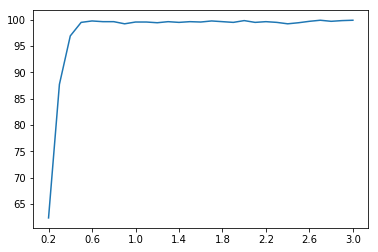

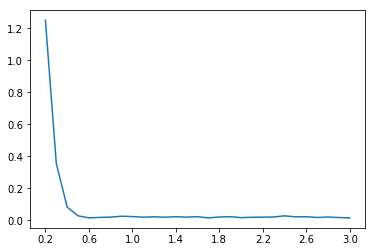

In [9]:
snr=np.linspace(0.2,3,29)
ac=[]
error=[]
for i in range(29):
    print(snr[i])
    test=generator_f(testsig,1480,snr[i],X,Y_)
    a,c=sess.run([accuracy,cross_entropy],feed_dict=test)
    print('test:'+' accuracy:'+str(a)+' cross_entropy:'+str(c))
    ac.append(a)
    error.append(c)
test=generator_f(testsig,1480,0.25,X,Y_)
a,c=sess.run([accuracy,cross_entropy],feed_dict=test)
print('snr=0.25:'+' accuracy:'+str(a)+' cross_entropy:'+str(c))
plt.figure()
plt.xticks(np.linspace(0.2,3,8))
plt.plot(snr,ac)
plt.figure()
plt.xticks(np.linspace(0.2,3,8))
plt.plot(snr,error)
plt.show()

    